# The Code

In [74]:
import numpy as np
from fontTools.misc.cython import returns
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [75]:
from sklearn.decomposition import FastICA

def performICA(data, heartbeats_only=True):
    heartbeats = []
    ica = FastICA(n_components=4)
    data = data.T
    components = ica.fit_transform(data)
    for i in range(4):
        component = components[:, i]
        if np.min(component) < -2: component *= -1
        if np.max(component) > 4: heartbeats.append(component)
        if not heartbeats_only and np.max(component) <= 5: heartbeats.append(5)
    return heartbeats

## load Data and apply ICA 

In [76]:
file_range = range(153)
all_heartbeats = []
for i in file_range:
    filename = f'{i}'.zfill(3)
    data = loadmat(f'heartbeat_data/{filename}.mat')
    data_matrix = np.array(data['val'][0])
    heartbeats = performICA(data_matrix)
    for h in heartbeats:
        all_heartbeats.append((h, filename))

In [ ]:
!pip install heartpy

In [77]:
import heartpy as hp
from scipy.signal import find_peaks

def check_rotation(component, sr):
    distance = sr/10
    _, properties = find_peaks(component, distance=distance, height=0.1 * np.max(component))
    _ , inverted_properties = find_peaks(-component, distance=distance, height=0.1 * np.max(-component))

    # calculate average peak height for normal and inverted peaks to determine if signal is upside down or not
    avg_peak_height = np.mean(properties['peak_heights']) 
    avg_inv_peak_height = np.mean(inverted_properties['peak_heights']) 

    # flip signal if inverted peaks are taller
    if avg_inv_peak_height > avg_peak_height:
        component = -component

    return component

def calculate_heartrate(component, sr):
    component = check_rotation(component, sr)
    working_data, measures, heart_rate = None, None, None

    # Analyze the component signal with HeartPy
    working_data, measures = hp.process(component, sample_rate=sr)

    return component, working_data, measures

In [78]:
import warnings
warnings.simplefilter('ignore')

heartbeatsWithBpm = np.zeros(len(all_heartbeats), dtype=tuple)

for i, heartbeat in enumerate(all_heartbeats):
    try:
        component, working_data, measures = calculate_heartrate(heartbeat[0], 360)
        heartbeatsWithBpm[i] = (heartbeat[0], heartbeat[1], measures['bpm'], measures['pnn50'])
    except:
        heartbeatsWithBpm[i] = (None, None, None, None)
        continue

## Divide signals into fetal and Maternal Signals

In [80]:
mother = []
fetus = []

fetusBpmMin = 110

for hb in heartbeatsWithBpm:
    if hb[2] == None:
        continue
    if hb[2] >= fetusBpmMin: fetus.append((hb[0],hb[1]))
    elif hb[2] < fetusBpmMin: mother.append((hb[0],hb[1]))

## Features for Clustering
Aligned Signal:
- Signals of formerly different lengths now have the same length 

Matrix profile of aligned Signal: 
- Captures Anomalies within a time series, the peaks (highes distance) within the matrix profile indicate anomalies within a tim series 
- is shorter that the original signal:
- normalize matrix profile values
Input time series length: n
Subsequence length: m
Matrix Profile length: n−m+1

Frequency:
- 1 number  for example the dominat frequency 


## @ New  

## Step 1 Align Data via Dynamic Time Warping
#### to the first fetal signal recorded at 000.mat

In [249]:
print(len(fetus))

138


In [250]:
# Print out the name to make sure we really got the file 000.mat
central_heartbeat = fetus[0]
central_heartbeat

(array([-0.36300318, -0.27301603, -0.29009801, ...,  0.39512346,
         0.36169046,  0.23049564]),
 '000')

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


aligned_heartbeats = []
for hp in fetus:
    # Example time series
    a = central_heartbeat[0]
    b = hp[0]
    
    # Reshape inputs to 2D (each point is a 1D vector)
    # fastdtw expects inputs as sequences of vectors (e.g., 2D arrays, even for 1D time series)
    
    a_reshaped = a.reshape(-1, 1)
    b_reshaped = b.reshape(-1, 1)
    # Compute fast DTW
    distance, path = fastdtw(a_reshaped, b_reshaped, dist=euclidean)
    
    # If b is longer than a, down-sample b using the DTW path
    aligned_b = []
    
    # Ensure that b aligns with a by down-sampling or repeating points from b
    for i in range(len(a)):  # Iterate over each point in a
        # Find the closest matching index in b (from the DTW path)
        closest_b_index = [j for (i_, j) in path if i_ == i]
        if closest_b_index:
            aligned_b.append(b[closest_b_index[0]])  
    # Convert to numpy arrays
    aligned_b = np.array(aligned_b) 
   
    aligned_heartbeats.append((aligned_b,hp[1]))

In [253]:
len(aligned_heartbeats)

138

In [254]:
len(aligned_heartbeats[1][0])

1500

In [255]:
len(aligned_heartbeats[3][0])

1500

In [256]:
aligned_heartbeats[3][1]

'002'

In [305]:
aligned_heartbeats_Matrix = np.array([aligned_heartbeat[0] for aligned_heartbeat in aligned_heartbeats])
aligned_heartbeats_Matrix.shape

(138, 1500)

#### Example of alignment with Dynamic Time Warping with FastDTW package

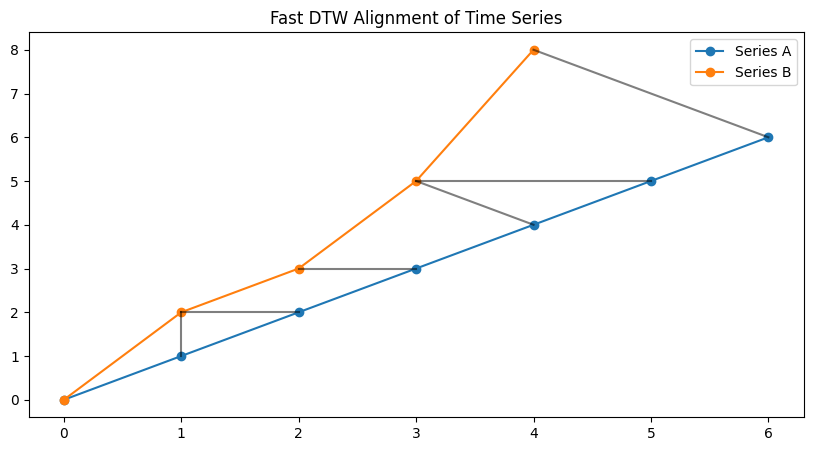

Distance between the two series: 4.0
Path for alignment (a -> b): [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (5, 3), (6, 4)]
Aligned Series A: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Aligned Series B: [np.int64(0), np.int64(2), np.int64(2), np.int64(3), np.int64(5), np.int64(5), np.int64(8)]


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Example time series
a = np.array([0, 1, 2, 3, 4, 5, 6])
b = np.array([0, 2, 3, 5, 8])

# Reshape inputs to 2D (each point is a 1D vector)
# fastdtw expects inputs as sequences of vectors (e.g., 2D arrays, even for 1D time series)

a_reshaped = a.reshape(-1, 1)
b_reshaped = b.reshape(-1, 1)

# Compute fast DTW
distance, path = fastdtw(a_reshaped, b_reshaped, dist=euclidean)

# Extract aligned series
aligned_a = [a[i] for i, _ in path]
aligned_b = [b[j] for _, j in path]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(a, label="Series A", marker="o")
plt.plot(b, label="Series B", marker="o")
for (i, j) in path:
    plt.plot([i, j], [a[i], b[j]], "k-", alpha=0.5)
plt.legend()
plt.title("Fast DTW Alignment of Time Series")
plt.show()

# Print results
print("Distance between the two series:", distance)
print("Path for alignment (a -> b):", path)
print("Aligned Series A:", aligned_a)
print("Aligned Series B:", aligned_b)


## Step 2 Scale and filter the Data

In [303]:
from scipy.signal import butter, filtfilt, find_peaks
# Function to filter signals with a low-pass filter
def butter_lowpass_filter(data, cutoff=20, fs=360, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [306]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

# Standardize fetal signals and apply filtering
scaler = StandardScaler()
fetus_signals = [hb for hb in aligned_heartbeats_Matrix]
stdFetus = scaler.fit_transform(fetus_signals)
stdFetusFiltered = [butter_lowpass_filter(x) for x in stdFetus]

In [309]:
stdFetusFiltered = np.array(stdFetusFiltered)
stdFetusFiltered.shape

(138, 1500)

## Step 3 Apply PCA to aligned Heartbeat Signals

In [321]:
# Function to compute and visualize cumulative variance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def plot_cumulative_variance(explained_variance_ratio, max_components=None):
    """
    Plots the cumulative variance explained by the first n principal components.
    
    Parameters:
    - explained_variance_ratio: array-like, variance explained by each component
    - max_components: int, maximum number of components to consider (default: all)
    """
    if max_components is None or max_components > len(explained_variance_ratio):
        max_components = len(explained_variance_ratio)
    
    # Compute cumulative variance
    cumulative_variance = np.cumsum(explained_variance_ratio[:max_components])
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_components + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.axhline(y=0.9, color='r', linestyle='-', label='90% Variance Threshold')
    plt.legend()
    plt.show()

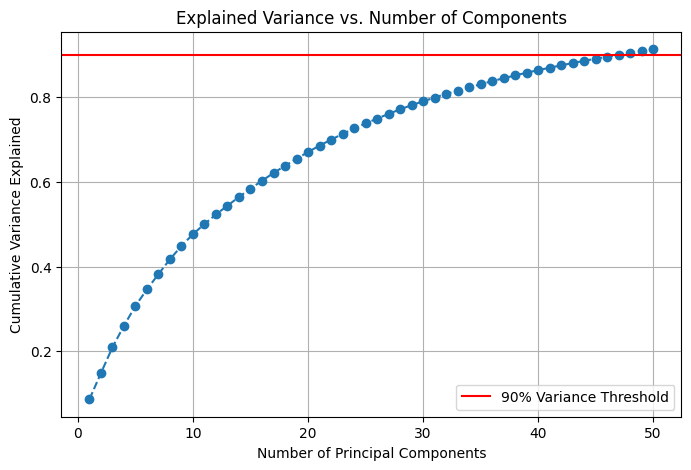

In [322]:
from sklearn.decomposition import PCA

# Perform PCA keeping only the top 2 principal components
pca = PCA(n_components=50)
aligned_fetus_reduced = pca.fit_transform(stdFetusFiltered)
explained_variance_ratio_fetus_filtered = pca.explained_variance_ratio_
plot_cumulative_variance(explained_variance_ratio_fetus_filtered)

In [323]:
aligned_fetus_reduced.shape

(138, 50)

### Step 4 Apply GMM to the reduced representation of the aligned heartbeat signals

In [324]:
from sklearn.mixture import GaussianMixture

# Fit the GMM
gmmData = aligned_fetus_reduced
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm.fit(gmmData)
weights = gmm.weights_
print("Weights of each Gaussian component:", weights)
means = gmm.means_
print("Means of each Gaussian component:\n", means)
covariances = gmm.covariances_
print("Covariances of each Gaussian component:\n", covariances)

Weights of each Gaussian component: [1.]
Means of each Gaussian component:
 [[-2.83187322e-16  9.78283477e-16 -1.15849359e-15  5.14886040e-16
  -3.86164530e-16  4.63397436e-16  7.72329061e-16  3.08931624e-16
  -1.13274929e-15  1.08126068e-15 -1.02977208e-15  8.75306269e-16
   3.58006700e-16 -7.46584759e-16  6.17863248e-16  2.57443020e-16
  -2.83187322e-16  5.66374644e-16 -3.08931624e-16  1.54465812e-16
  -1.54465812e-16 -1.54465812e-16 -3.08931624e-16 -1.15849359e-16
   6.69351853e-16 -1.02977208e-16  3.08931624e-16  2.57443020e-16
  -4.15126870e-16  6.43607551e-17  1.02977208e-16 -3.60420228e-16
   5.47066418e-17  2.05954416e-16  4.63397436e-16  6.43607551e-16
   9.33230948e-17 -5.08449965e-16 -3.25021813e-16  6.17863248e-16
  -6.43607551e-17  1.02977208e-16 -8.36689816e-17 -7.72329061e-17
  -6.17863248e-16 -5.30976229e-17  6.62915777e-16  3.86164530e-17
   2.57443020e-17 -5.08449965e-16]]
Covariances of each Gaussian component:
 [[[ 9.53109295e+01 -2.25363240e-14  6.17934381e-14 ... 

[-114.27948315 -116.20896257 -175.88359107 -145.1282945  -118.78802781
 -138.04667216 -152.58932586 -177.87437515 -155.32732649 -126.92871009
 -127.77617863 -139.83530725 -116.53460537 -119.51445676 -131.96637423
 -141.1543872  -133.71302046 -164.41696159 -152.62572163 -114.89750398
 -131.99889975 -116.63247207 -130.61628255 -125.77380498 -117.49941459
 -118.53906356 -126.23567999 -163.32537117 -140.24941171 -137.18934787
 -124.62902322 -131.88192065 -145.98575055 -151.56567529 -152.65172075
 -125.68484651 -119.80308451 -174.9712047  -173.53593375 -142.90344407
 -133.61931297 -148.38297215 -123.36441567 -119.99567318 -155.58703812
 -159.84930481 -121.65228825 -122.65154453 -155.09596748 -168.88098838
 -156.44080858 -146.09748974 -123.81972078 -138.76505548 -118.74314488
 -117.57765927 -154.6625129  -119.56724749 -124.49560795 -150.77282718
 -162.02029047 -132.30453306 -125.98939504 -167.32997196 -162.05340869
 -143.61424122 -129.08564076 -178.73272334 -146.16475612 -131.6804309
 -124.3

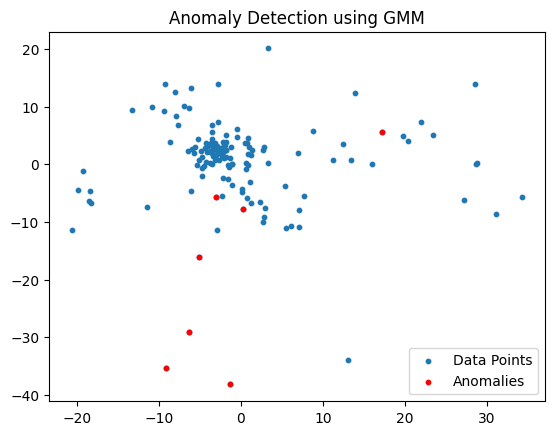

In [325]:
# Calculate the probability of each data point
scores = gmm.score_samples(gmmData)

# Set the threshold for anomalies
threshold = np.percentile(scores, 5)

# Identify anomalies
anomalies = gmmData[scores < threshold]
anomalies_idx= list(np.where(scores < threshold)[0])

import matplotlib.pyplot as plt

print(scores)
plt.scatter(gmmData[:, 0], gmmData[:, 1], s=10, label='Data Points')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

[-114.27948315 -116.20896257 -175.88359107 -145.1282945  -118.78802781
 -138.04667216 -152.58932586 -177.87437515 -155.32732649 -126.92871009
 -127.77617863 -139.83530725 -116.53460537 -119.51445676 -131.96637423
 -141.1543872  -133.71302046 -164.41696159 -152.62572163 -114.89750398
 -131.99889975 -116.63247207 -130.61628255 -125.77380498 -117.49941459
 -118.53906356 -126.23567999 -163.32537117 -140.24941171 -137.18934787
 -124.62902322 -131.88192065 -145.98575055 -151.56567529 -152.65172075
 -125.68484651 -119.80308451 -174.9712047  -173.53593375 -142.90344407
 -133.61931297 -148.38297215 -123.36441567 -119.99567318 -155.58703812
 -159.84930481 -121.65228825 -122.65154453 -155.09596748 -168.88098838
 -156.44080858 -146.09748974 -123.81972078 -138.76505548 -118.74314488
 -117.57765927 -154.6625129  -119.56724749 -124.49560795 -150.77282718
 -162.02029047 -132.30453306 -125.98939504 -167.32997196 -162.05340869
 -143.61424122 -129.08564076 -178.73272334 -146.16475612 -131.6804309
 -124.3

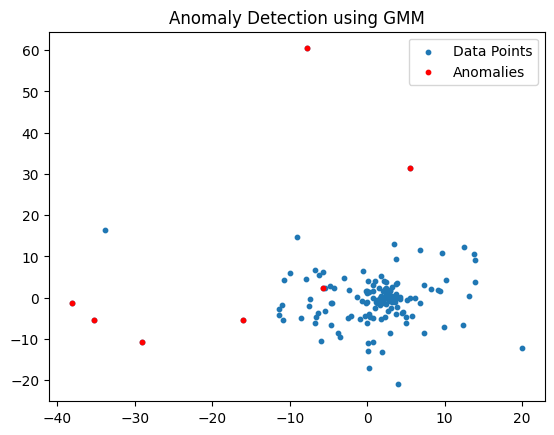

In [326]:
print(scores)
plt.scatter(gmmData[:, 1], gmmData[:, 2], s=10, label='Data Points')
plt.scatter(anomalies[:, 1], anomalies[:, 2], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

In [327]:
anomalies_idx

[np.int64(2),
 np.int64(7),
 np.int64(37),
 np.int64(38),
 np.int64(49),
 np.int64(67),
 np.int64(82)]

### Step 4 Plot Outliers

In [328]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def dominant_frequency(component, sr):
    freqs = fftfreq(len(component), 1 / sr)
    fft_vals = np.abs(fft(component))
    peak_freq = freqs[np.argmax(fft_vals)]
    return peak_freq

def plot_samples(matrix, sample_indices=None, sr=360):
    """
    Plots each sample from a given matrix with its own subplot.

    Parameters:
        matrix (numpy.ndarray): A matrix of shape (numberOfSamples, numberOfFeatures).
        sample_indices (list, optional): A list of indices to plot specific samples.
                                          If None, plot all samples.
        sr (int, optional): Sampling rate or a relevant parameter needed for frequency analysis.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix)

    # Determine which samples to plot
    if sample_indices is not None:
        # Filter matrix to only include specified rows
        matrix = matrix[sample_indices]
    else:
        sample_indices = list(range(matrix.shape[0]))

    # Create subplots: One subplot per sample
    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, num_samples * 3), sharex=True)

    # If there's only one subplot (one sample), make sure `axes` is a list for iteration
    if num_samples == 1:
        axes = [axes]

    # Plot each sample in its own subplot
    for i, ax in enumerate(axes):
        sample = fetus[i][0]
        sample_idx = sample_indices[i]

        # Plot the sample
        ax.plot(sample, label=f'Sample {sample_idx}')
        print(sample.shape)
        sample_freq = dominant_frequency(sample,360)
        sample_bpm = sample_freq*60
        sample_file = fetus[sample_idx][1]

        # Set titles and labels for the subplot
        ax.set_title(f"File {sample_file} | Sample {sample_idx} | Frequency: {sample_freq:.2f} Hz | BPM: {sample_bpm:.2f}")
        ax.set_ylabel("Feature Value = Current")
        ax.legend()
        ax.grid(True)

    # Set the x-axis label only once at the bottom
    plt.xlabel("Feature Index = Time")#
    plt.tight_layout()

    plt.show()

(1500,)
(2365,)
(1760,)
(1760,)
(2523,)
(1852,)
(2080,)


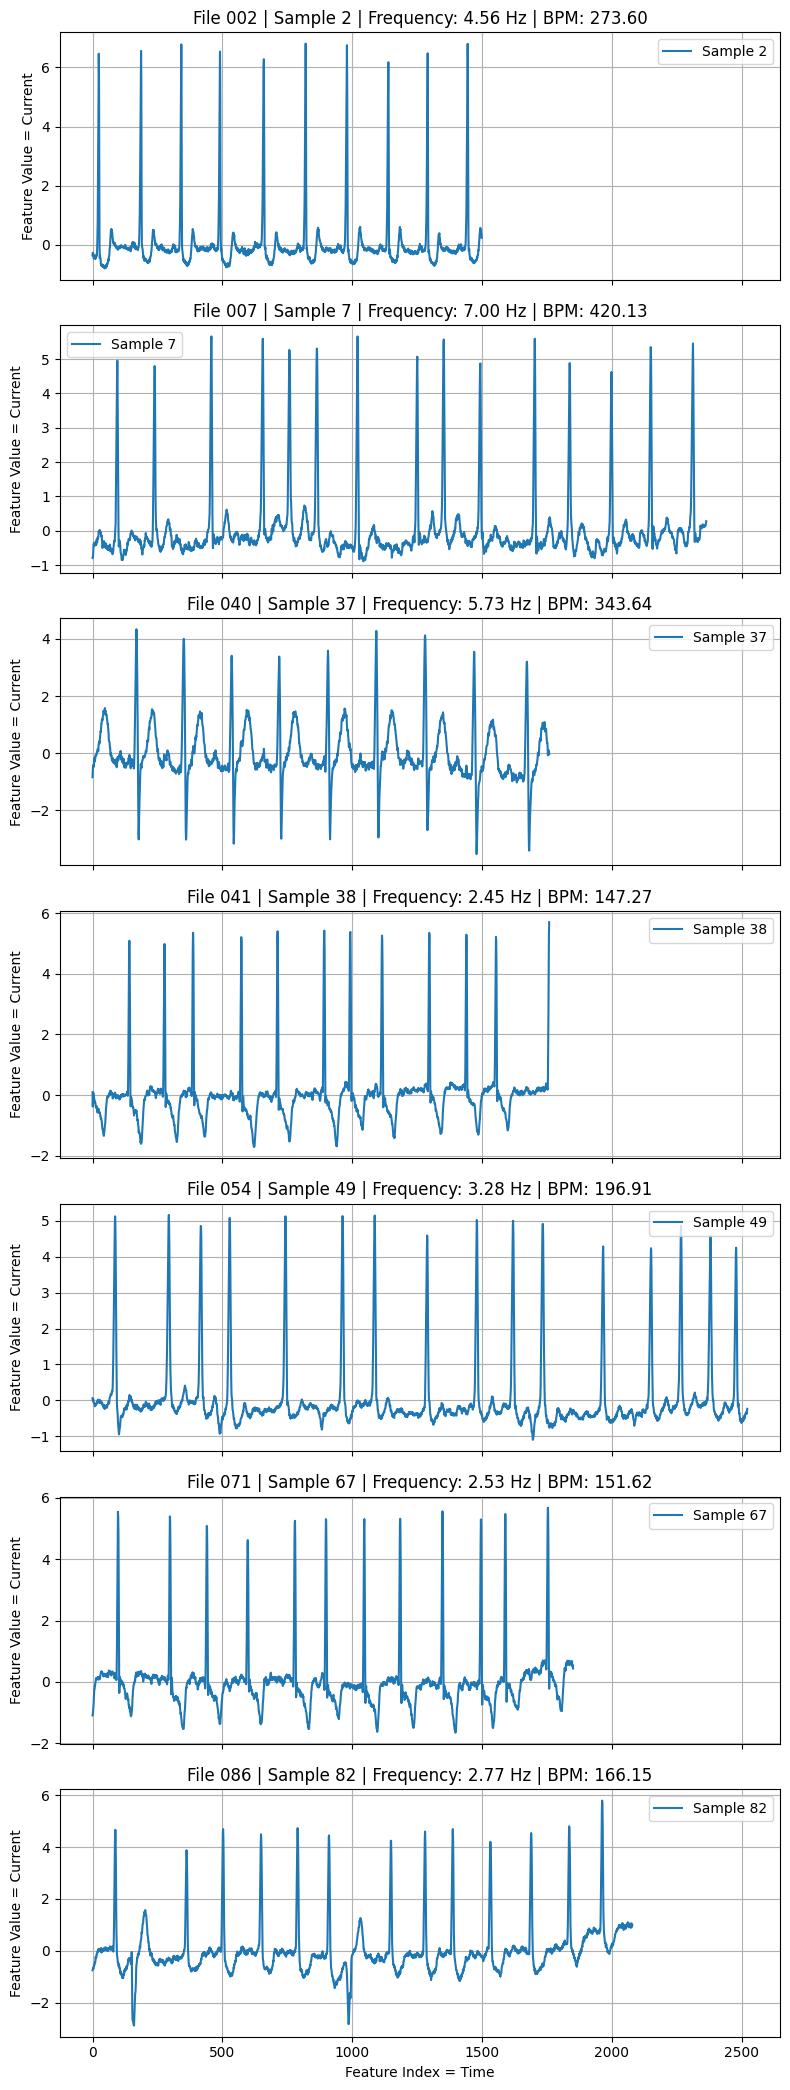

In [329]:
plot_samples(aligned_heartbeats_Matrix, anomalies_idx)

## GMM Clustering with Matrix Profiles







package: https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

why use the matrix profile? : https://www.youtube.com/watch?v=T9_z7EpA8QM

papers: https://www.cs.ucr.edu/~eamonn/MatrixProfile.html

### Step 1 Compute the matrix profile with the aligned, standardized  and filtered heartbeats

In [331]:
stdFetusFiltered.shape

(138, 1500)

In [332]:
import numpy as np
import stumpy

def compute_distance_profiles(signal_matrix, m):
    """
    Compute the distance profiles for a matrix of signals using STUMPY.
    
    Parameters:
    - signal_matrix: numpy.ndarray of shape (n_samples, n_measures)
        The input matrix where each row represents a time series signal.
    - m: int
        The subsequence window size for computing the matrix profile.
        
    Returns:
    - profile_matrix: numpy.ndarray of shape (n_samples, n_profiles)
        A 2D array where each row is the distance profile for a corresponding signal.
    """
    if not isinstance(signal_matrix, np.ndarray):
        raise ValueError("signal_matrix must be a numpy array.")
    
    n_samples, _ = signal_matrix.shape
    profiles = []
    
    for i in range(n_samples):
        signal = signal_matrix[i]
        distance_profile = stumpy.stump(signal, m)[:, 0]  # Extract matrix profile column
        profiles.append(distance_profile)
    
    # Convert the list of profiles to a 2D NumPy array
    profile_matrix = np.array(profiles)
    
    return profile_matrix

In [333]:
aligned_heartbeats_profiles = compute_distance_profiles(stdFetusFiltered, m=50)

In [334]:
aligned_heartbeats_profiles.shape

(138, 1451)

### Step 2 Apply PCA to the matrix Profiles

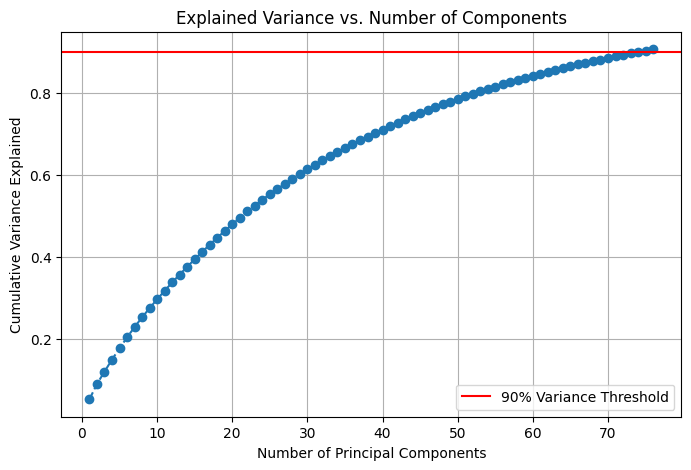

In [346]:
from sklearn.decomposition import PCA
# Perform PCA keeping only the top 2 principal components
pca = PCA(n_components=76)
aligned_profiles_reduced=pca.fit_transform(aligned_heartbeats_profiles)
explained_variance_ratio_profiles= pca.explained_variance_ratio_
plot_cumulative_variance(explained_variance_ratio_profiles)

In [347]:
aligned_profiles_reduced.shape

(138, 76)

### Step 3 Apply GMM to the reduces representation of the matrix profiles

In [348]:
from sklearn.mixture import GaussianMixture
# Fit the GMM
gmmData= aligned_profiles_reduced
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm.fit(gmmData)
weights = gmm.weights_
print("Weights of each Gaussian component:", weights)
means = gmm.means_
print("Means of each Gaussian component:\n", means)
covariances = gmm.covariances_
print("Covariances of each Gaussian component:\n", covariances)

Weights of each Gaussian component: [1.]
Means of each Gaussian component:
 [[-5.14886040e-16  1.13274929e-15 -7.72329061e-17 -3.08931624e-16
  -7.07968306e-16 -5.14886040e-17  1.02977208e-16  1.02977208e-16
   9.52539175e-16  5.14886040e-17 -1.54465812e-15 -2.57443020e-16
  -1.14562144e-15 -1.54465812e-15  6.50043626e-16  3.47548077e-16
  -4.11908832e-16  5.79246795e-16  1.01689993e-15 -1.44168091e-15
   1.39019231e-15  0.00000000e+00 -4.11908832e-16  2.31698718e-16
   1.39019231e-15  7.72329061e-17  8.75306269e-16 -8.75306269e-16
   1.14562144e-15  6.17863248e-16 -8.27035702e-16  1.15849359e-16
   9.01050571e-17 -1.23572650e-15  2.05954416e-16 -2.34916756e-16
  -9.13922722e-16 -3.02495549e-16 -2.57443020e-17  4.63397436e-16
  -3.08931624e-16  7.33712608e-16 -3.86164530e-16 -1.02977208e-15
  -1.60901888e-15 -9.01050571e-17  9.52539175e-16  2.04345397e-16
  -1.83428152e-16 -6.30735399e-16 -3.71683360e-16 -6.43607551e-16
  -9.46103099e-16  7.07968306e-17 -1.38375623e-16  1.19328862e-15


[-184.29206497 -189.86906795 -201.16246777 -196.38355577 -197.23994581
 -180.9940151  -191.1117106  -202.08296277 -193.34631658 -182.61165471
 -188.84732833 -183.41311801 -187.77784129 -185.39649804 -194.50091079
 -195.3102179  -186.91250981 -184.77309817 -192.90655457 -185.87854309
 -189.70806438 -186.16921681 -195.21162813 -191.94761363 -186.69767424
 -190.55415877 -185.94685439 -193.50739285 -188.1233501  -193.95464887
 -188.34008014 -183.7066438  -200.97795406 -190.65248878 -187.58662283
 -191.38910021 -191.02898293 -200.52372708 -190.95050049 -198.78814729
 -186.79387015 -199.05741379 -190.80352728 -184.12841493 -202.24572334
 -189.96633207 -186.62708446 -193.65112734 -202.34454829 -189.17668152
 -193.40403393 -182.61794709 -195.56460824 -198.96935047 -190.88604516
 -185.17385746 -201.31214083 -185.7233301  -186.94482402 -193.29950343
 -196.97668438 -190.83986599 -189.02150173 -196.38569441 -197.06546137
 -190.65216546 -189.90463545 -201.59294713 -188.20574338 -184.53741116
 -183.

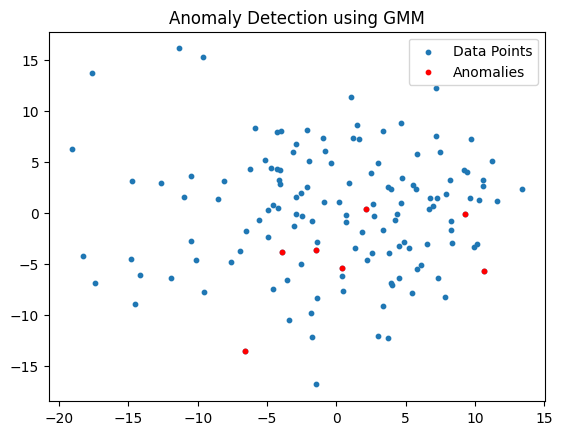

In [349]:
# Calculate the probability of each data point
scores = gmm.score_samples(gmmData)

# Set the threshold for anomalies
threshold = np.percentile(scores, 5)

# Identify anomalies
anomalies = gmmData[scores < threshold]
anomalies_idx= list(np.where(scores < threshold)[0])

import matplotlib.pyplot as plt

print(scores)
plt.scatter(gmmData[:, 0], gmmData[:, 1], s=10, label='Data Points')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

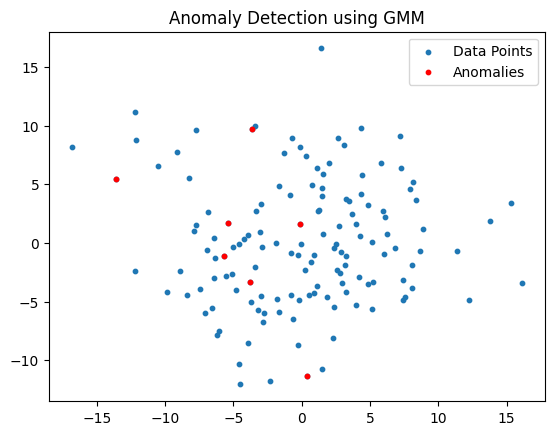

In [350]:
plt.scatter(gmmData[:, 1], gmmData[:, 2], s=10, label='Data Points')
plt.scatter(anomalies[:, 1], anomalies[:, 2], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

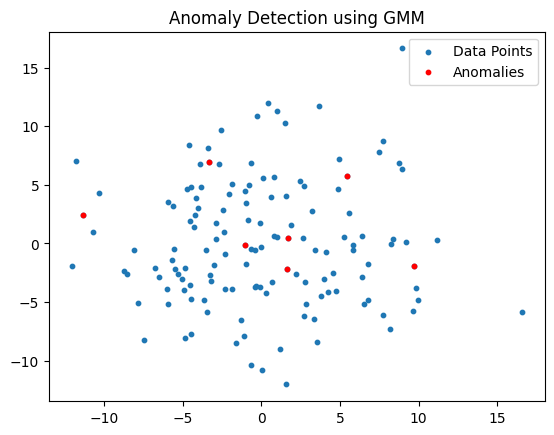

In [351]:
plt.scatter(gmmData[:, 2], gmmData[:, 3], s=10, label='Data Points')
plt.scatter(anomalies[:, 2], anomalies[:, 3], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

In [344]:
anomalies_idx

[np.int64(7),
 np.int64(32),
 np.int64(44),
 np.int64(67),
 np.int64(81),
 np.int64(82),
 np.int64(133)]

### Step 4 Plot Outliers

(1500,)
(2365,)
(1760,)
(1760,)
(2523,)
(1852,)
(2080,)


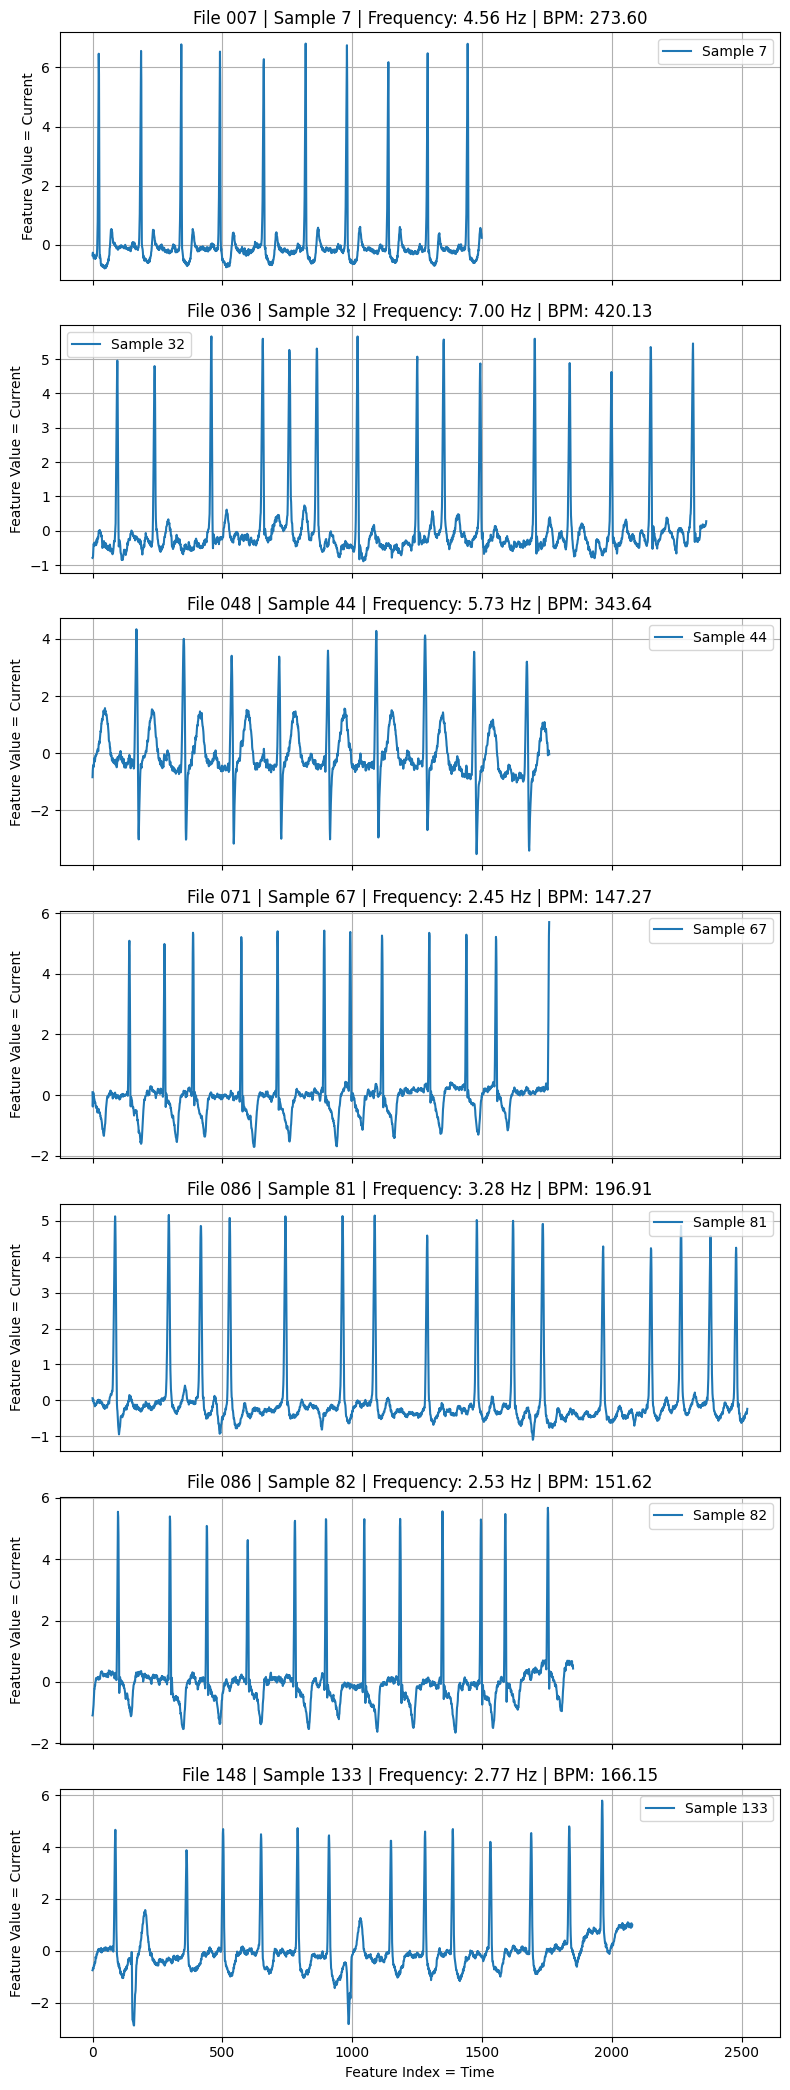

In [345]:
plot_samples(aligned_heartbeats_Matrix, anomalies_idx)